In [2]:
import os
import sys

seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [3]:
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')

In [4]:
import numpy as np
import pandas as pd
import time
import random

from tensorflow.random import set_seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import load_model

In [7]:
# Add modules path
module_path = os.path.abspath('../..')
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from src.data_reader import DataReader
from src.feature_extraction import get_principal_components, dimensionality_reduction
from src.metrics import compute_evaluation_metrics
from src.model import create_mlp_model, get_callbacks
from src.model_evaluation import evaluate_mlp, evaluate_mlp_multiple_splits
from src.plotting import plot_loss_curves
from src.serialization import load_object, save_object
from src.training import train_mlp, MLPConfigParams
from src.utils import numbers_list_to_string

In [9]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [10]:
# Set input and output paths
filename = '../data/N-CMAPSS_DS02-006.h5'
output_path = '../results/experiment_set_PCA_new'

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [11]:
PCA_EXPLAINED_VARIANCE = 0.999

In [12]:
def train_evaluate_mlp_pca(x_train, y_train,
                           x_test, y_test,
                           num_trials,
                           mlp_config_params,
                           results_path,
                           epochs, batch_size, results_file=None):
    mse_vals = []
    rmse_vals = []
    cmapss_vals = []
    
    for trial_num in range(num_trials):
        # Train-validation split for early stopping
        x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train,
                                                                                  y_train,
                                                                                  test_size=0.1,
                                                                                  random_state=trial_num)
        # Create output path
        results_path_crr_split = os.path.join(results_path, f"split_{trial_num}")
        if not os.path.exists(results_path_crr_split):
            os.makedirs(results_path_crr_split)
    
        # Standardization
        scaler_file = os.path.join(results_path_crr_split, 'scaler.pkl')
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_split)
        x_val_scaled = scaler.transform(x_val_split)
        x_test_scaled = scaler.transform(x_test)
        save_object(scaler, scaler_file)
    
        # PCA
        pca = get_principal_components(x_train_scaled, debug=True, 
                                       explained_variance=PCA_EXPLAINED_VARIANCE,
                                       output_path_plots=output_path)
        pca_file = os.path.join(results_path_crr_split, 'pca.pkl')
        save_object(pca, pca_file)
    
        x_train_final = dimensionality_reduction(x_train_scaled, pca)
        x_val_final = dimensionality_reduction(x_val_scaled, pca)
        x_test_final = dimensionality_reduction(x_test_scaled, pca)
        input_dim = x_train_final.shape[1]
    
        # Create model
        weights_file = os.path.join(results_path, 'mlp_initial_weights.h5')
        model_path = os.path.join(results_path_crr_split, 'mlp_model_trained.h5')
    
        # Save initial weights
        if trial_num == 0:
            model = create_mlp_model(input_dim,
                                     hidden_layer_sizes=mlp_config_params.layer_sizes,
                                     activation=mlp_config_params.activation,
                                     dropout=mlp_config_params.dropout,
                                     output_weights_file=weights_file)
        else:
            model = create_mlp_model(input_dim,
                                     hidden_layer_sizes=mlp_config_params.layer_sizes,
                                     activation=mlp_config_params.activation,
                                     dropout=mlp_config_params.dropout)
        model.summary()
    
        # Train model
        history = train_mlp(model,
                            x_train_final, y_train_split,
                            x_val_final, y_val_split,
                            weights_file=weights_file,
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=get_callbacks(model_path))
    
        history_file = os.path.join(results_path_crr_split, f"history_{trial_num}.pkl")
        plot_loss_curves(history.history)
        save_object(history.history, history_file)
    
        # Performance evaluation
        loaded_model = load_model(model_path)
        predictions_test = loaded_model.predict(x_test_final).flatten()
        mse, rmse, cmapss_score = compute_evaluation_metrics(predictions_test, y_test)
    
        mse_vals.append(mse)
        rmse_vals.append(rmse)
        cmapss_vals.append(cmapss_score)
    
    mse_mean = np.mean(mse_vals)
    mse_std = np.std(mse_vals)
    rmse_mean = np.mean(rmse_vals)
    rmse_std = np.std(rmse_vals)
    cmapss_mean = np.mean(cmapss_vals)
    cmapss_std = np.std(cmapss_vals)

    if results_file is not None:
        with open(results_file, "a") as file:
            line_to_write = f"{numbers_list_to_string(mse_vals)}, {numbers_list_to_string(rmse_vals)},"
            line_to_write += f"{numbers_list_to_string(cmapss_vals)}, {mse_mean}, {mse_std}, {rmse_mean},"
            line_to_write += f"{rmse_std}, {cmapss_mean}, {cmapss_std}\n"
            file.write(line_to_write)
    
    print("MSE: mean = {:.2f}   stddev = {:.2f}".format(mse_mean, mse_std))
    print("RMSE: mean = {:.2f}   stddev = {:.2f}".format(rmse_mean, rmse_std))
    print("CMAPSS: mean = {:.2f}   stddev = {:.2f}".format(cmapss_mean, cmapss_std))

In [13]:
data_reader = DataReader()

start_time = time.process_time()  
data_reader.load_dataset(filename, load_train=True, load_test=True)
print("Operation time (sec): " , (time.process_time() - start_time))

if data_reader.train_set is not None:
    print("Train set shape: " + str(data_reader.train_set.shape))
    
if data_reader.test_set is not None:   
    print("Test set shape: " + str(data_reader.test_set.shape))

Operation time (sec):  4.3125
Train set shape: (5263447, 47)
Test set shape: (1253743, 47)


In [14]:
train_set = data_reader.train_set
test_set = data_reader.test_set

In [15]:
y_train = train_set['RUL']
x_train = train_set.drop(['RUL'], axis=1)

In [16]:
# selected_columns = data_reader.column_names.w_cols + data_reader.column_names.x_s_cols + data_reader.column_names.x_v_cols
selected_columns = data_reader.column_names.w_cols + data_reader.column_names.x_s_cols
x_train = x_train[selected_columns]

y_test = test_set['RUL']
x_test = test_set[x_train.columns]

In [17]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_0\scaler.pkl
Can reduce from 32 to 6 dimensions while retaining 0.999% of variance.
Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_0\pca.pkl
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1792      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
To

Epoch 25/60
9250/9253 [============================>.] - ETA: 0s - loss: 20.1999
Epoch 00025: val_loss improved from 21.01108 to 20.15604, saving model to ../results/experiment_set_PCA_new\results_pca_mlp1\split_0\mlp_model_trained.h5
9253/9253 [==============================] - 38s 4ms/step - loss: 20.2011 - val_loss: 20.1560
Epoch 26/60
9244/9253 [============================>.] - ETA: 0s - loss: 20.0421
Epoch 00026: val_loss did not improve from 20.15604
9253/9253 [==============================] - 38s 4ms/step - loss: 20.0415 - val_loss: 20.1966
Epoch 27/60
9249/9253 [============================>.] - ETA: 0s - loss: 19.9892
Epoch 00027: val_loss improved from 20.15604 to 20.13655, saving model to ../results/experiment_set_PCA_new\results_pca_mlp1\split_0\mlp_model_trained.h5
9253/9253 [==============================] - 38s 4ms/step - loss: 19.9889 - val_loss: 20.1365
Epoch 28/60
9245/9253 [============================>.] - ETA: 0s - loss: 19.8408
Epoch 00028: val_loss did not impr

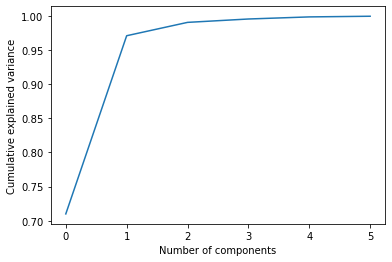

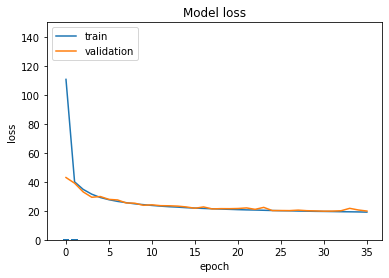

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_0\history_0.pkl
Test set:
MSE: 72.74
RMSE: 8.53
CMAPSS score: 1.90

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_1\scaler.pkl
Can reduce from 32 to 6 dimensions while retaining 0.999% of variance.
Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_1\pca.pkl
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               1792      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 64)            

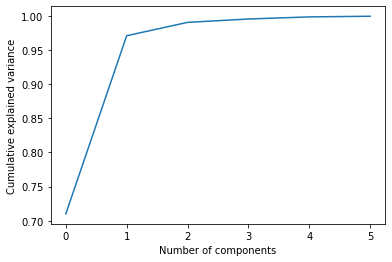

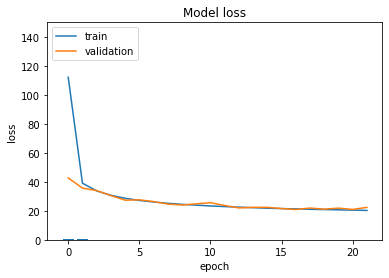

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_1\history_1.pkl
Test set:
MSE: 70.17
RMSE: 8.38
CMAPSS score: 1.87

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_2\scaler.pkl
Can reduce from 32 to 6 dimensions while retaining 0.999% of variance.
Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_2\pca.pkl
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               1792      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 64)            

Epoch 24/60
9251/9253 [============================>.] - ETA: 0s - loss: 20.1781
Epoch 00024: val_loss improved from 20.95913 to 20.39026, saving model to ../results/experiment_set_PCA_new\results_pca_mlp1\split_2\mlp_model_trained.h5
9253/9253 [==============================] - 38s 4ms/step - loss: 20.1780 - val_loss: 20.3903
Epoch 25/60
9250/9253 [============================>.] - ETA: 0s - loss: 20.0391
Epoch 00025: val_loss did not improve from 20.39026
9253/9253 [==============================] - 36s 4ms/step - loss: 20.0384 - val_loss: 22.8190
Epoch 26/60
9253/9253 [==============================] - ETA: 0s - loss: 19.8794
Epoch 00026: val_loss did not improve from 20.39026
9253/9253 [==============================] - 36s 4ms/step - loss: 19.8794 - val_loss: 20.7942
Epoch 27/60
9243/9253 [============================>.] - ETA: 0s - loss: 19.7264
Epoch 00027: val_loss improved from 20.39026 to 20.28487, saving model to ../results/experiment_set_PCA_new\results_pca_mlp1\split_2\mlp

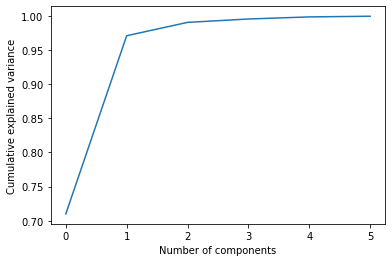

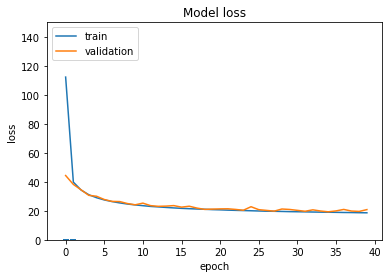

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_2\history_2.pkl
Test set:
MSE: 71.57
RMSE: 8.46
CMAPSS score: 1.89

MSE: mean = 71.49   stddev = 1.05
RMSE: mean = 8.46   stddev = 0.06
CMAPSS: mean = 1.88   stddev = 0.01


In [17]:
#################################################
# Test effect of PCA for feature extraction - FS2
#################################################
NUM_TRIALS = 3
EPOCHS = 60
BATCH_SIZE = 512

mlp_params = MLPConfigParams(layer_sizes=[256, 256, 512, 64], activation='tanh', dropout=0.0)

results_path = os.path.join(output_path, "results_pca_mlp1")
if not os.path.exists(results_path):
    os.makedirs(results_path)

results_file = os.path.join(output_path, "results_pca_mlp1.csv")
with open(results_file, "w") as file:
    file.write("mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")

train_evaluate_mlp_pca(
    x_train, y_train, 
    x_test, y_test,
    NUM_TRIALS, 
    mlp_params, 
    results_path, 
    EPOCHS, BATCH_SIZE,
    results_file=results_file)

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_0\scaler.pkl
Can reduce from 18 to 5 dimensions while retaining 0.999% of variance.
Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_0\pca.pkl
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
To

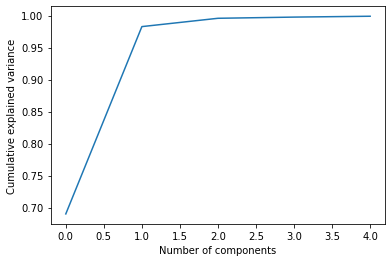

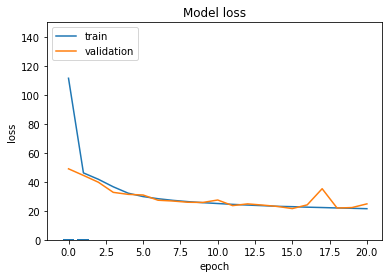

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_0\history_0.pkl
Test set:
MSE: 65.07
RMSE: 8.07
CMAPSS score: 1.82

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_1\scaler.pkl
Can reduce from 18 to 5 dimensions while retaining 0.999% of variance.
Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_1\pca.pkl
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 64)            

Epoch 26/60
9243/9253 [============================>.] - ETA: 0s - loss: 20.5337
Epoch 00026: val_loss did not improve from 20.68469
9253/9253 [==============================] - 37s 4ms/step - loss: 20.5324 - val_loss: 21.0175
Epoch 00026: early stopping


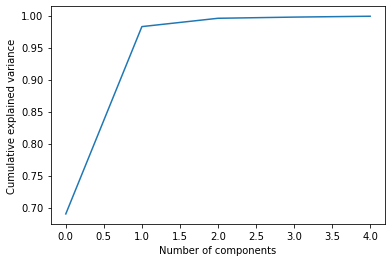

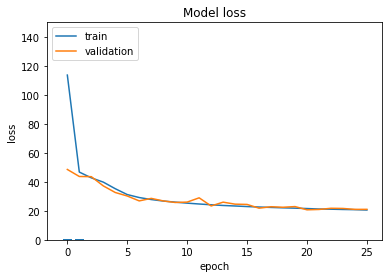

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_1\history_1.pkl
Test set:
MSE: 68.22
RMSE: 8.26
CMAPSS score: 1.83

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_2\scaler.pkl
Can reduce from 18 to 5 dimensions while retaining 0.999% of variance.
Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_2\pca.pkl
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 64)            

Epoch 24/60
9247/9253 [============================>.] - ETA: 0s - loss: 20.7388
Epoch 00024: val_loss did not improve from 20.27370
9253/9253 [==============================] - 37s 4ms/step - loss: 20.7399 - val_loss: 21.7533
Epoch 25/60
9245/9253 [============================>.] - ETA: 0s - loss: 20.6235
Epoch 00025: val_loss did not improve from 20.27370
9253/9253 [==============================] - 37s 4ms/step - loss: 20.6224 - val_loss: 20.8066
Epoch 26/60
9241/9253 [============================>.] - ETA: 0s - loss: 20.4392
Epoch 00026: val_loss did not improve from 20.27370
9253/9253 [==============================] - 37s 4ms/step - loss: 20.4391 - val_loss: 21.2188
Epoch 27/60
9250/9253 [============================>.] - ETA: 0s - loss: 20.3328
Epoch 00027: val_loss did not improve from 20.27370
9253/9253 [==============================] - 37s 4ms/step - loss: 20.3326 - val_loss: 20.5460
Epoch 28/60
9247/9253 [============================>.] - ETA: 0s - loss: 20.2182
Epoch 00028

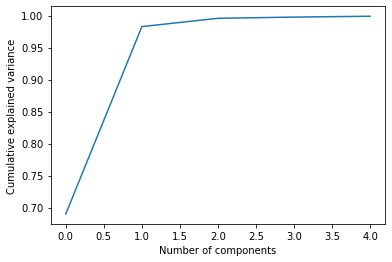

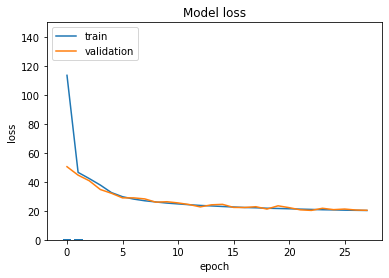

Saved object to file: ../results/experiment_set_PCA_new\results_pca_mlp1\split_2\history_2.pkl
Test set:
MSE: 66.45
RMSE: 8.15
CMAPSS score: 1.82

MSE: mean = 66.58   stddev = 1.29
RMSE: mean = 8.16   stddev = 0.08
CMAPSS: mean = 1.82   stddev = 0.01


In [18]:
#################################################
# Test effect of PCA for feature extraction - FS3
#################################################
NUM_TRIALS = 3
EPOCHS = 60
BATCH_SIZE = 512

mlp_params = MLPConfigParams(layer_sizes=[256, 256, 512, 64], activation='tanh', dropout=0.0)

results_path = os.path.join(output_path, "results_pca_mlp1")
if not os.path.exists(results_path):
    os.makedirs(results_path)

results_file = os.path.join(output_path, "results_pca_mlp1.csv")
with open(results_file, "w") as file:
    file.write("mse,rmse,cmapss,mse(mean),mse(std),rmse(mean),rmse(std),cmapss(mean),cmapss(std)\n")

train_evaluate_mlp_pca(
    x_train, y_train, 
    x_test, y_test,
    NUM_TRIALS, 
    mlp_params, 
    results_path, 
    EPOCHS, BATCH_SIZE,
    results_file=results_file)